# Visualizing the Aftermath of the Eaton and Palisades Fires
**Author**: Joshua Ferrer-Lozano  
**Date**: Dec 12, 2025  
**GitHub Repository**: [Joshua Ferrer-Lozano](https://github.com/Awoo56709/eds220-hw4)

# About

In January 2025, the Eaton and Palisades Fires broke out in Los Angeles County, burning more than 16,000 structures, forcing mass evacuations, and resulting in at least 28 fatalities (Phillips, 2025). Beyond the immediate destruction, these fires left long‑lasting ecological and social impacts. Understanding both the burn severity and the social vulnerability of affected communities is crucial for disaster response and recovery planning.

This blog post combines satellite imagery analysis and social vulnerability data to examine the fires. Using Landsat 8 surface reflectance data, I created true‑color and false‑color composites to visualize burn scars and vegetation loss. I then integrated the Environmental Justice Index (EJI) dataset to assess how wildfire exposure overlapped with vulnerable populations, focusing on minority populations. Together, these analyses highlight how geospatial data science can reveal both ecological damage and social disparities.

# Highlights of the analysis

- Processed fire perimeter shapefiles with GeoPandas to ensure consistent CRS and geometry.

- Restored CRS and handled missing values in Landsat 8 imagery.

- Created true‑color composites for baseline visualization and false‑color composites to highlight burn scars.

- Overlaid fire boundaries on imagery to confirm burn extent.

- Clipped EJI census tracts to fire perimeters and mapped minority population indicators.


# Dataset descriptions

**Eaton and Palisades Fire Perimeter Data**:

The Eaton and Palisades dissolved Fire Perimeter (2025) data published by Los Angeles County, provides shapefiles of dissolved polygons of the Eaton and Palisades fire perimeters. These files of which were daily perimeter snapshots, were merged to create a single fire perimeter for each fire. This dataset was from the NIFC FIRIS fire service and is hosted on ArcGIS Hub containing data for both fires. You can access the data [here](https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about).

**Landsat 8 Data**: 

Landsat 8 Data NetCDF dataset containing atmospherically corrected reflectance data from Landsat 8 via the Microsoft Planetary Computer. Includes spectral bands (red, green, blue, near-infrared, shortwave infrared) clipped to the Eaton and Palisades fire perimeters. You can access the data [here](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2).

**Environmental Justice Index (EJI) Data**: 

Census-tract level socioeconomic and demographic indicators estimating vulnerability, recovery potential, and mitigation capacity. Variables include population, housing, transportation, and socioeconomic status. You can access the data [here](https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html).




## Step 1: Import Libraries & Load Data


### Setup
Load the needed packages, import fire perimeters, Landsat bands and EJI data.

### Load in Libraries

In [2]:

# Import required libraries for geospatial analysis and visualization
import os
import numpy as np
import rioxarray as rio
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
# Activate and Import netCDF4
import netCDF4
# Check activation and version
print(netCDF4.__version__)

1.7.3


### Load Fire Perimeter, Landsat and EJI Data

Fire perimeters provide the spatial boundaries of interest for the analysis.


In [4]:
# Load fire perimeter shapefiles
eaton = gpd.read_file('data\eaton_fire\Eaton_Perimeter_20250121.shp')

# Load fire perimeter shapefiles
palisades = gpd.read_file('data\palisades_fire\Palisades_Perimeter_20250121.shp')

# Generate variable for path
NC_fp = os.path.join('data','landsat8-2025-02-23-palisades-eaton.nc')

# Use netCDF4
landsat = xr.open_dataset("data/landsat8-2025-02-23-palisades-eaton.nc", engine="netcdf4")

# Read in the EJI dataset
ca_eji_fp = 'data/EJI_2024_California/EJI_2024_California.gdb'
ca_eji = gpd.read_file(ca_eji_fp)

## Prepare Landsat Data

### Restoring Spatial Information

The Landsat dataset includes a ***spatial_ref*** variable but does not automatically recognize its CRS. We restored the CRS to EPSG:32611 (WGS 84 / UTM zone 11N) to ensure proper alignment with fire perimeter polygons. Clouded areas contained missing values (NaNs), which we replaced with zeros to allow clean visualization.


In [7]:

# Recover the geospatial information from spatial_ref
landsat = landsat.rio.write_crs(landsat.spatial_ref.crs_wkt)
# Substitute any nan values for 0
landsat = landsat.fillna(0)

# Identify which bands have nan values using numpy.isnan()
nan_bands = []
for band in ['red', 'green', 'blue', 'nir08', 'swir22']:
    if np.isnan(landsat[band]).any():
        nan_bands.append(band)

print("Bands with NaN values:", nan_bands)



Bands with NaN values: []


## True Color Visualization

A true‑color composite combines the red, green, and blue bands to produce a natural‑looking image of the fire area. This visualization provides a baseline view of the landscape as it would appear to the human eye, helping establish context before moving to false‑color analysis.

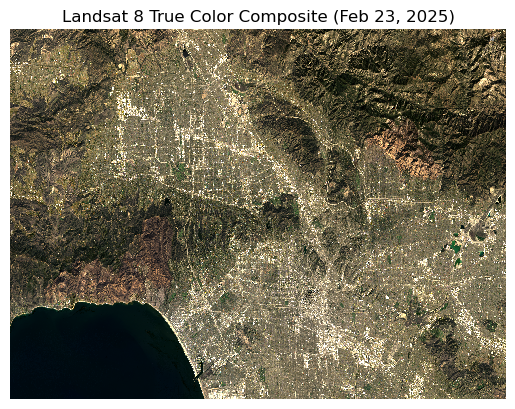

Text(0.5, -0.05, 'Figure 1. Landsat 8 true‑color composite of the Eaton and Palisades fire area, showing the landscape as it appears to the human eye. Source: Microsoft Planetary Computer (Landsat 8 Collection 2 Level‑2).')

<Figure size 640x480 with 0 Axes>

In [8]:
# Re-plot with the true color image
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)
plt.title('Landsat 8 True Color Composite (Feb 23, 2025)')
plt.axis('off')
plt.show()
plt.figtext(0.5, -0.05, "Figure 1. Landsat 8 true‑color composite of the Eaton and Palisades fire area, showing the landscape as it appears to the human eye. Source: Microsoft Planetary Computer (Landsat 8 Collection 2 Level‑2).",
            wrap=True, ha="center", fontsize=10)


The **robust=True** parameter ensures that extreme outliers (such as bright clouds) do not distort the color scaling.

## False Color Visualization

False‑color imagery uses non‑visible wavelengths to highlight features that are difficult to discern in true color. By assigning SWIR → Red, NIR → Green, and Red → Blue, we create a composite where healthy vegetation appears bright green, burned areas appear reddish‑brown, and urban areas appear in neutral tones. This visualization makes fire impacts much more visible.

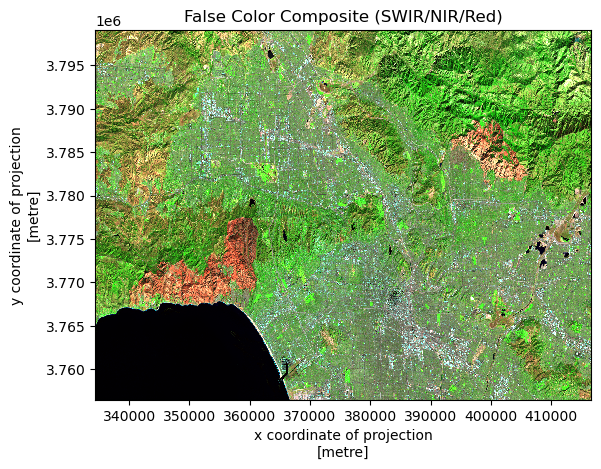

Text(0.5, -0.05, 'Figure 1. Landsat 8 true‑color composite of the Eaton and Palisades fire area, showing the landscape as it appears to the human eye. Source: Microsoft Planetary Computer (Landsat 8 Collection 2 Level‑2).')

<Figure size 640x480 with 0 Axes>

In [31]:
# Specify bands for false color composite
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)
plt.title('False Color Composite (SWIR/NIR/Red)')
plt.show()
plt.figtext(0.5, -0.05, "Figure 1. Landsat 8 true‑color composite of the Eaton and Palisades fire area, showing the landscape as it appears to the human eye. Source: Microsoft Planetary Computer (Landsat 8 Collection 2 Level‑2).",
            wrap=True, ha="center", fontsize=10)


## Visualize False Color Image with Fire Perimeters

To confirm spatial alignment, we reprojected the fire perimeter shapefiles to match the Landsat CRS. Overlaying these boundaries on the false‑color composite allows us to directly compare burn scars with official fire data. In the visualization, the Eaton Fire perimeter is outlined in red and the Palisades Fire in blue.

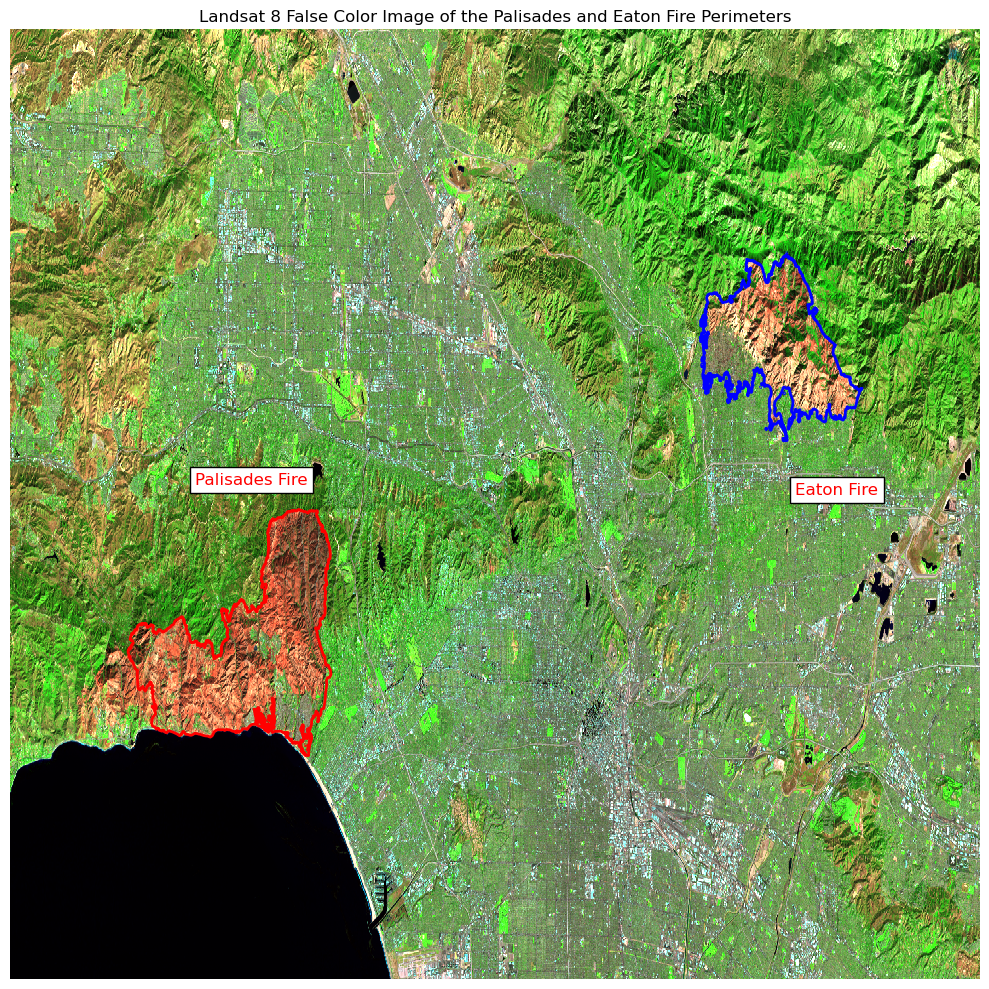

Text(0.5, -0.05, 'Figure 3. False‑color composite with Eaton (red outline) and Palisades (blue outline) fire perimeters overlaid, confirming alignment between burn scars and official fire boundaries. Source: Los Angeles County Fire Perimeter Data (2025), Microsoft Planetary Computer.')

<Figure size 640x480 with 0 Axes>

In [32]:
# Reproject fire perimeters to match Landsat CRS
eaton = eaton.to_crs(landsat.rio.crs)
palisades = palisades.to_crs(landsat.rio.crs)

# Create comprehensive map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot false color composite
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(
    ax=ax,
    robust=True,
    add_colorbar=False
)
# Add Palisades and Eaton fire perimeters
eaton.boundary.plot(ax=ax, edgecolor='blue', linewidth=2)
palisades.boundary.plot(ax=ax, edgecolor='red', linewidth=2)


# Add false color raster
landsat[["swir22", "nir08", "red"]].to_array().plot.imshow(robust=True)

# Add title
ax.set_title('Landsat 8 False Color Image of the Palisades and Eaton Fire Perimeters')

# Add labels with gray background
plt.figtext(0.20, 0.51, "Palisades Fire", color='red', fontsize=12, bbox=dict(facecolor='white'))
plt.figtext(0.80, 0.50, "Eaton Fire", color='red', fontsize=12, bbox=dict(facecolor='white'))

# Remove axes
ax.axis('off')

# Display the map
plt.tight_layout()
plt.show()

plt.figtext(0.5, -0.05, "Figure 3. False‑color composite with Eaton (red outline) and Palisades (blue outline) fire perimeters overlaid, confirming alignment between burn scars and official fire boundaries. Source: Los Angeles County Fire Perimeter Data (2025), Microsoft Planetary Computer.",
            wrap=True, ha="center", fontsize=10)


**Figure Interpretation**

The Eaton fire (overlaid in blue) and the Palisades fire (overlaid in red) outline the burn perimeter. This false color composite displays the Eaton and Palisades fire areas captured by Landsat 8 on February 23, 2025. The image uses **shortwave infrared (SWIR)**, **near-infrared (NIR)**, and **red** bands to highlight burn scars and vegetation health.

**Key features:**

- **Bright green areas**: Healthy vegetation (high NIR reflectance)
- **Reddish-brown areas**: Burned areas and bare soil (low NIR, moderate SWIR)
- **Urban/developed areas**: Neutral colors (moderate reflectance across bands)


# Social Vulnerability (EJI)

This analysis examines socioeconomic characteristics of communities impacted by the fires. While fires affect all habitats, they do not impact all communities equally. We used the Environmental Justice Index (EJI) to identify socioeconomic vulnerability within fire perimeters.

In this example, the code focuses on the low‑income population variable, but the same workflow can be applied to other indicators (e.g., elderly residents, disability prevalence). Mapping these values within fire boundaries highlights communities that may face greater challenges during evacuation and recovery.


Match the CRS of the EJI data to Landsat data.

In [11]:
# Reproject all datasets to the same crs
eaton = eaton.to_crs(ca_eji.crs)
palisades = palisades.to_crs(ca_eji.crs)


Clip EJI data to the fire perimeter extents.

In [12]:
# Clip tracts to the palisades and eaton fire perimeters
eji_palisades_clip = gpd.clip(ca_eji, palisades)
eji_eaton_clip = gpd.clip(ca_eji, eaton)


Return the intersecting census tracks in the fire perimeter.

In [13]:
# Get the EJI tracts intersecting the palisades fire perimeter
eji_palisades_join = gpd.sjoin(ca_eji, palisades, how='inner', predicate='intersects')

## Visialize Social Vulnerability

Social vulnerability varies significantly across communities affected by wildfires. To understand which areas may face greater challenges during and after the fires, we visualize the EJI indicator for minority populations within census tracts intersecting the Eaton and Palisades fire perimeters.

In this analysis, we focus on the proportion of residents identified as minority populations. These communities often experience disproportionate impacts from disasters due to systemic inequities, including reduced access to resources, barriers to recovery assistance, and heightened exposure to environmental hazards. By comparing the spatial distribution of minority populations across the Palisades and Eaton fire areas, we can identify neighborhoods that may require additional support and targeted interventions.

This dual map showcases the percentage of minority residents in census tracts within each fire perimeter. This comparison reveals whether one fire disproportionately affected communities with higher concentrations of socially vulnerable minority populations, highlighting the importance of integrating demographic data into disaster response planning.

C:\Users\joshu\AppData\Local\Temp\ipykernel_24776\705066373.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


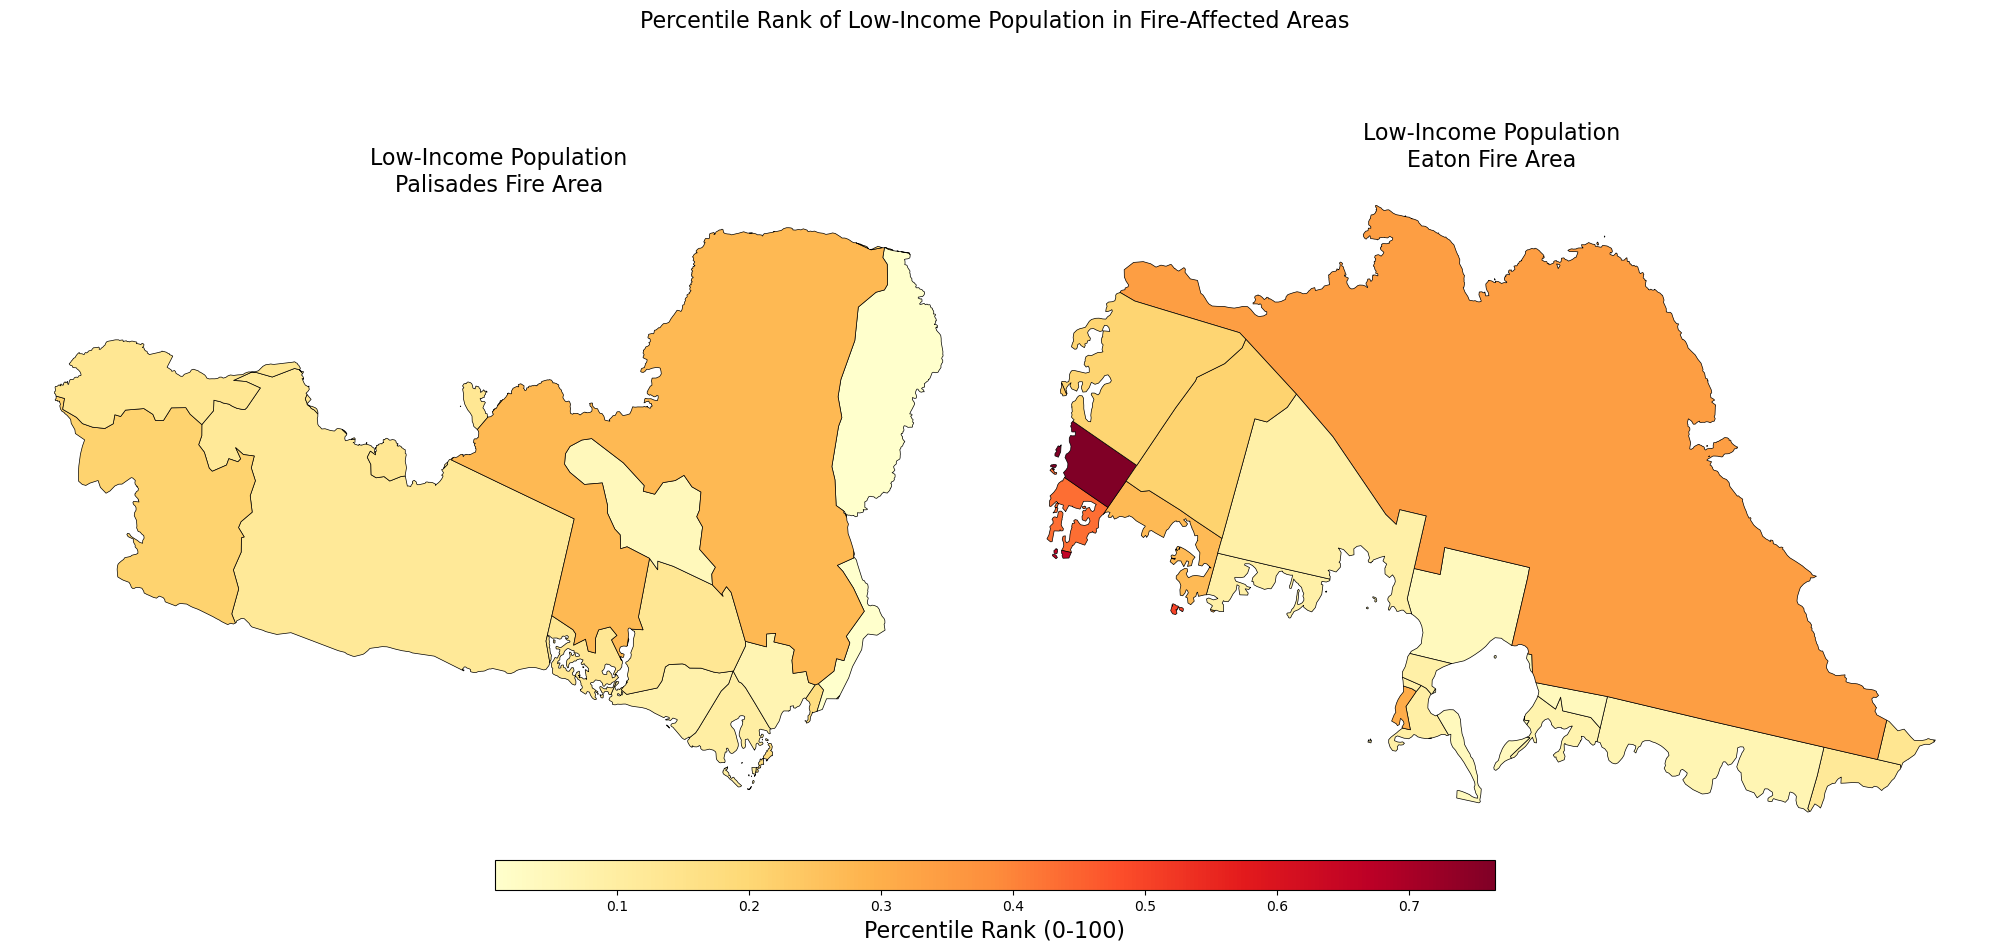

Text(0.5, -0.05, 'Figure 4. Environmental Justice Index (EJI) minority population indicator mapped within census tracts intersecting the Eaton and Palisades fire perimeters. Darker shades represent higher percentages of minority residents. Source: CDC/ATSDR Environmental Justice Index (2024).')

<Figure size 640x480 with 0 Axes>

In [33]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Define common scale for comparison
eji_variable = 'EPL_POV200'
#eji_variable = 'E_AGE65'
vmin = min(eji_palisades_clip[eji_variable].min(),
           eji_eaton_clip[eji_variable].min())
vmax = max(eji_palisades_clip[eji_variable].max(),
           eji_eaton_clip[eji_variable].max())


# Eaton Plot
eji_eaton_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    cmap='YlOrRd',
    legend=False,
    ax=ax2,
    edgecolor='black',
    linewidth=0.5
)
ax2.set_title('Low-Income Population\nEaton Fire Area',
              fontsize=16)
ax2.axis('off')


# Palisades Plot
eji_palisades_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    cmap='YlOrRd',
    legend=False,
    ax=ax1,
    edgecolor='black',
    linewidth=0.5
)
ax1.set_title('Low-Income Population\nPalisades Fire Area',
              fontsize=16)
ax1.axis('off')

# Overall title
fig.suptitle('Percentile Rank of Low-Income Population in Fire-Affected Areas',
             fontsize=16)

# Shared colorbar
sm = plt.cm.ScalarMappable(
    cmap='YlOrRd',
    norm=plt.Normalize(vmin=vmin, vmax=vmax)
)
cbar_ax = fig.add_axes([0.25, 0.10, 0.5, 0.03])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percentile Rank (0-100)', fontsize=16)

plt.tight_layout()
plt.show()

plt.figtext(0.5, -0.05, "Figure 4. Environmental Justice Index (EJI) minority population indicator mapped within census tracts intersecting the Eaton and Palisades fire perimeters. Darker shades represent higher percentages of minority residents. Source: CDC/ATSDR Environmental Justice Index (2024).",
            wrap=True, ha="center", fontsize=10)

## Figure Interpretation

This analysis reveals the socioeconmic vulnerability within each of the fire perimeters. The maps show percentile rankings of low-income population (households earning less than 200% of the federal poverty level) within census tracts. The higher percentile values (dark red) indicate greater economic vulnerability. 


**Eaton Fire Area:**

The burn area shows higher percentile rankings compared to the Palisades area, with large portions in the 50th-70th percentiles and some tracts reaching the 80th-90th percentiles (Altadena). On average, these darker areas demonstrate that fires disproportionately affected communities that are more socioeconomically vulnerable.

**Palisades Fire Area:**

The Palisades perimeter and its census tracts show predominantly low to moderate percentile rankings (roughly 10th-40th percentiles). This indicates that there was proportionaly less socioeconomically vulnerable communities affected by the Palisades fire.



**Environmental Justice Implications:**

These contrasting patterns reveal that while fires affect habitats, communities and individuals, those that are socioeconomically disadvantaged are disproportionaly affected due to less expendible income/assets that would otherwise allow for post-fire transition. This analysis does however provide a glimpse of how communities and local governments can:

- Train for Emergency preparedness
- Spot-targeting communities that are most vulnerable
- Plan for adaptation and mitigation strategies to address natural disasters

## Conclusion

By combining satellite imagery with census‑based vulnerability data, this analysis reveals both the ecological and social dimensions of wildfire impacts. False‑color composites highlight burn severity, while EJI data provide a flexible framework for exploring different aspects of community vulnerability. Whether focusing on income, age, disability, or health, this integrated approach shows not only where fires burned, but also which populations may face disproportionate challenges in recovery. As climate change intensifies wildfire risk, integrating physical and social data is essential for equitable disaster response and planning.




# References

Palisades and Eaton Dissolved Fire Perimeters. (2025). Fire perimeter shapefiles [Geospatial dataset]. ArcGIS Hub. https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c [Accessed Nov. 24, 2025]

U.S. Geological Survey. (2025). Landsat 8 Collection 2 Level-2 surface reflectance data [Satellite imagery dataset]. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2 [Accessed Nov. 24, 2025]

Bennett, M. M., Chen, J. K., Alvarez León, L. F., & Gleason, C. J. (2022). The politics of pixels: A review and agenda for critical remote sensing. Progress in Human Geography, 46(3), 729–752. https://doi.org/10.1177/03091325221074691 [Accessed Nov. 24, 2025]

Galaz García, C., Cawse-Nicholson, K., Frew, A., & Fontenot, R. (2024). EDS 220: Working with environmental datasets [Course materials]. Master of Environmental Data Science, Bren School of Environmental Science & Management, University of California, Santa Barbara. https://meds-eds-220.github.io/MEDS-eds-220-course/ [Accessed Nov. 24, 2025]

CDC/ATSDR. (2024). Environmental Justice Index (EJI). https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html [Accessed Nov. 24, 2025].